In [1]:
# model library
import tensorflow as tf

# image processing libraries
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image

# data processing libraries
import numpy as np
import matplotlib.pyplot as plt
import math

# folder reading libraries
import glob
import os

### Loading in model

In [46]:
model = tf.keras.models.load_model('../model/cyclic_voltammogram_model')

# add another layer to convert to probabilities
cv_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()]) # softmax layer converts inputs to probabilities


### Loading in experimental data

In [26]:
def gather_png_data(folder_path): # function to read in PNG image files
    files = glob.glob(folder_path + "/*.png")
    img_array = []
    l,t,r,b = 30,0,400,390 # left and top pixel until right and bottom pixel to crop that were arbitrarily set
    for img in files:
        img = load_img(img, color_mode = "grayscale")
        img = img.crop((l,t,r,b)) # cropping is better for model & training
        img = img_to_array(img)  # convert PIL format to numpy array (note: 255 is white and 0 black)
        img_array.append(img)
    img_array = np.array(img_array)
    # map values to 0-1 such that 0 represents white, 1 represents black: better for model to process since white is not needed
    img_array = -(img_array/255) + 1
    return img_array

def listdir_non_hidden(folder_path): # function to only gather non-hidden folders
    folders = []
    for folder in os.listdir(folder_path):
        if not folder.startswith('.'):
            folders.append(folder)
    return folders

rel_folder_path = ("../data/experimental data/") # folder path of training data relative to code, note: add "/" at end
categories = listdir_non_hidden(rel_folder_path)
data = []
class_names = []

# iterates through data folder and appends data into a list
for folders in categories:
    datas = gather_png_data(rel_folder_path + folders)
    data.append(datas)

exp_data = np.vstack(data)

# generates labels based on training data folder
training_folder = '../data/training data/data (E,v,lambda)/Line Plots'
data_folder = listdir_non_hidden(training_folder)
labels = []
for folders in data_folder:
    labels.append(folders)

### Predicting data

In [47]:
predictions = cv_model.predict(exp_data, batch_size = 32)

1/1 [==============================] - 0s 67ms/step


In [48]:
predictions[0]

array([0.00710735, 0.00565511, 0.00497269, 0.01990975, 0.00140996,
       0.00451849, 0.00601534, 0.00410571, 0.00122565, 0.02032067,
       0.00327456, 0.02726231, 0.05835713, 0.17442124, 0.20550668,
       0.23748858, 0.15783323, 0.06061549], dtype=float32)

### Functions to display images

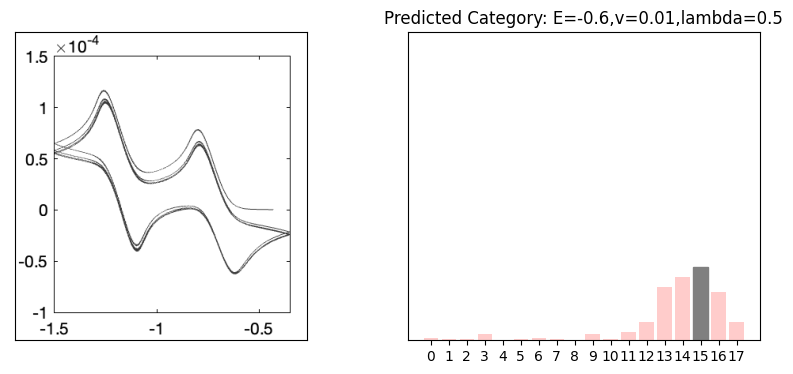

In [75]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(exp_data[0,:,:,0], cmap= "binary")
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.grid(False)
thisplot = plt.bar(range(len(labels)), predictions[0], color="#FFCCCB")
plt.xticks(range(len(labels)))
plt.yticks([])
plt.ylim([0, 1])
predicted_label = np.argmax(predictions[0])
thisplot[predicted_label].set_color('grey')
plt.title(f"Predicted Category: {labels[predicted_label]}")
plt.show()